# Braille Character Classification

## Importing the modules

In [1]:
import os
import numpy as np
import pandas as pd
from shutil import copyfile

## Creating labeled directories

In [10]:
os.mkdir('./charimages/')
alpha = 'a'
for i in range(0, 26): 
    os.mkdir('./charimages/' + alpha)
    alpha = chr(ord(alpha) + 1)

rootdir = '..\\Code\\brailleCharactersDataset\\BrailleDataset\\'
for file in os.listdir(rootdir):
    letter = file[0]
    copyfile(rootdir+file, './charimages/' + letter + '/' + file)

<!-- 
# Dataset

# Braille Character Dataset

# Source: Kaggle

# 28x28 image in BW Scale

# Augmentations:

# whs - width height shift

# rot – Rotation

# dim – brightness

# 26 characters * 3 Augmentations * 20 values
# = 1560 images 
-->

## Splitting the dataset

In [12]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=20,
                             shear_range=10,
                             validation_split=0.2)

train_generator = datagen.flow_from_directory('./charimages/',
                                              target_size=(28,28),
                                              subset='training')

val_generator = datagen.flow_from_directory('./charimages/',
                                            target_size=(28,28),
                                            subset='validation')

Found 1248 images belonging to 26 classes.
Found 312 images belonging to 26 classes.


## Model Definition & Training

In [13]:
from keras import backend as K
from keras import layers as L
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

K.clear_session()

model_ckpt = ModelCheckpoint('BrailleNet.h5',save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=8,verbose=0)
early_stop = EarlyStopping(patience=15,verbose=1)

entry = L.Input(shape=(28,28,3))
x = L.SeparableConv2D(64,(3,3),activation='relu')(entry)
x = L.MaxPooling2D((2,2))(x)
x = L.SeparableConv2D(128,(3,3),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.SeparableConv2D(256,(2,2),activation='relu')(x)
x = L.GlobalMaxPooling2D()(x)
x = L.Dense(256)(x)
x = L.LeakyReLU()(x)
x = L.Dense(64,kernel_regularizer=l2(2e-4))(x)
x = L.LeakyReLU()(x)
x = L.Dense(26,activation='softmax')(x)

model = Model(entry,x)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              validation_data=val_generator,
                              epochs=666,
                              callbacks=[model_ckpt,reduce_lr,early_stop],
                              verbose=1)

<ipython-input-13-709140038fe6>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/666
39/39 [==============================] - 9s 216ms/step - loss: 3.2844 - accuracy: 0.0337 - val_loss: 3.2555 - val_accuracy: 0.0481 - lr: 0.0010
Epoch 2/666
39/39 [==============================] - 2s 52ms/step - loss: 3.1941 - accuracy: 0.0681 - val_loss: 2.9830 - val_accuracy: 0.2019 - lr: 0.0010
Epoch 3/666
39/39 [==============================] - 2s 58ms/step - loss: 2.6107 - accuracy: 0.2500 - val_loss: 2.1255 - val_accuracy: 0.4423 - lr: 0.0010
Epoch 4/666
39/39 [==============================] - 2s 51ms/step - loss: 1.8905 - accuracy: 0.4511 - val_loss: 1.8175 - val_accuracy: 0.4359 - lr: 0.0010
Epoch 5/666
39/39 [==============================] - 2s 51ms/step - loss: 1.5943 - accuracy: 0.5264 - val_loss: 1.2025 - val_accuracy: 0.6571 - lr: 0.0010
Epoch 6/666
39/39 [==============================] - 2s 53ms/step - loss: 1.2751 - accuracy: 0.6466 - val_loss: 1.2614 - val_accuracy: 0.6090 - lr: 0.0010
Epoch 7/666
39/39 [==============================] - 2s 53ms/step - l

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 separable_conv2d (Separable  (None, 26, 26, 64)       283       
 Conv2D)                                                         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 separable_conv2d_1 (Separab  (None, 11, 11, 128)      8896      
 leConv2D)                                                       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                         

## Measuring Performance 

In [15]:
model = load_model('BrailleNet.h5')
acc = model.evaluate_generator(val_generator)[1]
print('model accuracy: {}'.format(round(acc,4)))


<ipython-input-15-11a8187ef6d0>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = model.evaluate_generator(val_generator)[1]


model accuracy: 0.9359


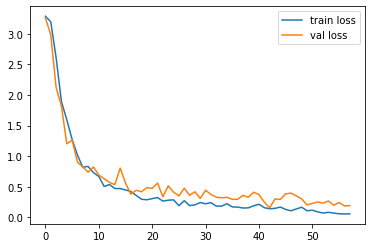

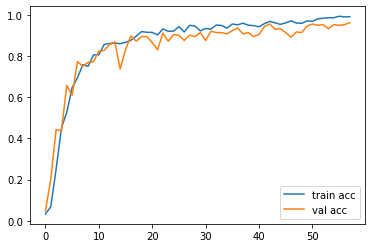

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

## Testing

In [29]:
pred = model.predict(val_generator)
a=np.argmax(pred, axis=1)
a

array([10, 19,  7, 15, 11, 16, 22, 14,  9,  4, 25, 25,  3,  8, 20, 11, 25,
        3,  5, 17, 14, 20, 21,  4,  5, 15,  1, 12, 12, 15, 23, 24, 24,  8,
        6,  2, 12,  7, 19, 11, 14,  9,  9, 16, 17, 12,  5, 10, 14,  0, 13,
       25, 21,  8,  1, 25, 24, 15, 20,  2,  3, 22, 19,  6, 10, 21,  7, 17,
       13, 24,  8,  7, 25, 24,  2, 16,  9, 17, 19,  0,  2, 10,  5, 11,  1,
        3, 18, 18, 13,  5, 22,  6, 19,  4, 19, 10, 24, 14, 22, 24, 20,  5,
        8,  5,  8, 16,  0, 24, 12,  7,  7, 14,  2, 25, 13, 21, 24, 10, 15,
       19, 12,  2,  8, 24, 25,  9, 21, 17,  4, 21,  5, 13,  4, 17, 14,  1,
        4,  1, 23, 25,  2,  6,  0, 23,  3,  1,  3,  9, 25, 16,  1, 16,  9,
       12, 16, 10,  5,  1, 12,  7,  6, 22,  8,  9,  1,  4, 23,  7, 24, 15,
        6,  4, 24, 11, 17, 23,  3,  2,  5, 17, 16, 22,  4,  7, 13, 21, 13,
       18, 17,  5,  2,  0, 13, 11, 22,  5, 10,  6,  1,  2, 17, 20, 18, 18,
        8, 18, 19,  5,  7,  1, 11, 24, 11, 20, 14,  8, 11, 14,  2, 15, 16,
        0, 25, 10, 21, 17

In [30]:
a.size

312

### Custom Test 

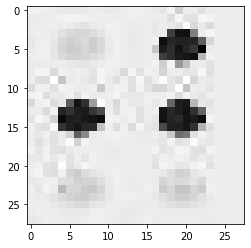

In [22]:
from tensorflow.keras.preprocessing import image
img=image.load_img('..\\Code\\brailleCharactersDataset\\BrailleDataset\\j1.JPG0dim.jpg')
plt.imshow(img)

In [23]:
x=image.img_to_array(img)
x

array([[[240., 240., 240.],
        [239., 239., 239.],
        [238., 238., 238.],
        ...,
        [237., 237., 237.],
        [237., 237., 237.],
        [237., 237., 237.]],

       [[235., 235., 235.],
        [235., 235., 235.],
        [236., 236., 236.],
        ...,
        [237., 237., 237.],
        [237., 237., 237.],
        [237., 237., 237.]],

       [[235., 235., 235.],
        [236., 236., 236.],
        [237., 237., 237.],
        ...,
        [237., 237., 237.],
        [237., 237., 237.],
        [237., 237., 237.]],

       ...,

       [[238., 238., 238.],
        [238., 238., 238.],
        [237., 237., 237.],
        ...,
        [237., 237., 237.],
        [237., 237., 237.],
        [237., 237., 237.]],

       [[236., 236., 236.],
        [238., 238., 238.],
        [238., 238., 238.],
        ...,
        [237., 237., 237.],
        [237., 237., 237.],
        [237., 237., 237.]],

       [[232., 232., 232.],
        [234., 234., 234.],
        [237., 2

In [24]:
x=np.expand_dims(x,axis=0)
model.predict(x)

array([[9.43415805e-30, 6.77444052e-29, 5.42249100e-19, 1.03055606e-10,
        3.71151291e-26, 1.44346479e-11, 4.21898467e-18, 6.29111888e-13,
        8.41704178e-15, 9.99990344e-01, 1.78716582e-34, 3.37341601e-21,
        4.59397385e-27, 1.31160357e-06, 3.63380370e-25, 1.16665805e-13,
        4.02758160e-10, 1.91988322e-17, 3.83493240e-16, 8.32674959e-06,
        6.53664880e-14, 9.93779337e-18, 2.97142555e-09, 2.80062490e-18,
        2.22693392e-13, 1.02353970e-09]], dtype=float32)

In [25]:
a=np.argmax(model.predict(x), axis=1)
a

array([9], dtype=int64)